In [1]:
import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import collections
import tqdm
import matplotlib.pyplot as plt

In [2]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
data_files = data_files = {
    "train": "label_text_short.csv",
    "valid": "label_text_valid.csv",
    "test": "label_text_test.csv"}

dataset = datasets.load_dataset("data", data_files=data_files)

Using custom data configuration data-cfc262799383c8fd


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/ben/.cache/huggingface/datasets/csv/data-cfc262799383c8fd/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'text'],
        num_rows: 499
    })
    valid: Dataset({
        features: ['label', 'title', 'text'],
        num_rows: 99
    })
    test: Dataset({
        features: ['label', 'title', 'text'],
        num_rows: 99
    })
})

In [5]:
train_data = dataset["train"]
valid_data = dataset["valid"]
test_data = dataset["test"]

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [7]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    length = len(tokens)
    return {"tokens": tokens, "length": length}

In [8]:
max_length = 256

train_data = train_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
valid_data = valid_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_example, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

  0%|          | 0/499 [00:00<?, ?ex/s]

  0%|          | 0/99 [00:00<?, ?ex/s]

  0%|          | 0/99 [00:00<?, ?ex/s]

In [9]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(train_data["tokens"],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [10]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [11]:
vocab.set_default_index(unk_index)

In [12]:
def numericalize_data(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [13]:
train_data = train_data.map(numericalize_data, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={"vocab": vocab})

  0%|          | 0/499 [00:00<?, ?ex/s]

  0%|          | 0/99 [00:00<?, ?ex/s]

  0%|          | 0/99 [00:00<?, ?ex/s]

In [14]:
train_data = train_data.with_format(type='torch', columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type='torch', columns=["ids", "label", "length"])
test_data = test_data.with_format(type='torch', columns=["ids", "label", "length"])

In [15]:
def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_ids = [i['ids'] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
        batch_label = [i['label'] for i in batch]
        batch_label = torch.stack(batch_label)
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch = {"ids": batch_ids,
                 "label": batch_label,
                 "length": batch_length}
        return batch
    
    return collate_fn

In [16]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    
    collate_fn = get_collate_fn(pad_index)
    
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    
    return data_loader

In [17]:
batch_size = 256

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional,
                 dropout_rate, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional,
                            dropout=dropout_rate, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, ids, length):
        # ids = [batch size, seq len]
        # length = [batch size]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, length, batch_first=True, 
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # hidden = [n layers * n directions, batch size, hidden dim]
        # cell = [n layers * n directions, batch size, hidden dim]
        output, output_length = nn.utils.rnn.pad_packed_sequence(packed_output)
        # output = [batch size, seq len, hidden dim * n directions]
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
            # hidden = [batch size, hidden dim * 2]
        else:
            hidden = self.dropout(hidden[-1])
            # hidden = [batch size, hidden dim]
        prediction = self.fc(hidden)
        # prediction = [batch size, output dim]
        return prediction

In [19]:
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = len(train_data.unique('label'))
n_layers = 2
bidirectional = True
dropout_rate = 0.3

model = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout_rate, pad_index)

In [20]:
pretrained_vectors = torchtext.vocab.GloVe(name="6B", dim=100)

.vector_cache/glove.6B.zip: 862MB [02:49, 5.08MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:08<00:00, 47915.52it/s]


In [21]:
pretrained_embedding = pretrained_vectors.get_vecs_by_tokens(vocab.get_itos())

In [22]:
model.embedding.weight.data = pretrained_embedding

In [23]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [25]:
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def train(data_loader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in tqdm.tqdm(data_loader, desc='training...', ncols=0):
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        length = batch["length"]
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [27]:
def evaluate(data_loader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc='evaluating...', ncols=0):
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            length = batch["length"]
            prediction = model(ids, length)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return np.mean(epoch_losses), np.mean(epoch_accs)

In [28]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [29]:
n_epochs = 25
best_valid_loss = float('inf')

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_data_loader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)

    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'lstm.pt')
    
    print(f'epoch: {epoch}')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')

training...: 100% 2/2 [00:00<00:00,  5.96it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.07it/s]


epoch: 0
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.699, valid_acc: 0.444


training...: 100% 2/2 [00:00<00:00, 11.73it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.08it/s]


epoch: 1
train_loss: 0.684, train_acc: 0.564
valid_loss: 0.687, valid_acc: 0.545


training...: 100% 2/2 [00:00<00:00, 12.09it/s]
evaluating...: 100% 1/1 [00:00<00:00, 35.86it/s]


epoch: 2
train_loss: 0.675, train_acc: 0.598
valid_loss: 0.697, valid_acc: 0.485


training...: 100% 2/2 [00:00<00:00, 11.91it/s]
evaluating...: 100% 1/1 [00:00<00:00, 35.35it/s]


epoch: 3
train_loss: 0.656, train_acc: 0.599
valid_loss: 0.685, valid_acc: 0.556


training...: 100% 2/2 [00:00<00:00, 12.01it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.02it/s]


epoch: 4
train_loss: 0.661, train_acc: 0.577
valid_loss: 0.681, valid_acc: 0.556


training...: 100% 2/2 [00:00<00:00, 12.25it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.43it/s]


epoch: 5
train_loss: 0.640, train_acc: 0.643
valid_loss: 0.682, valid_acc: 0.576


training...: 100% 2/2 [00:00<00:00, 12.19it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.36it/s]


epoch: 6
train_loss: 0.611, train_acc: 0.661
valid_loss: 0.705, valid_acc: 0.576


training...: 100% 2/2 [00:00<00:00, 12.24it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.87it/s]


epoch: 7
train_loss: 0.597, train_acc: 0.676
valid_loss: 0.687, valid_acc: 0.616


training...: 100% 2/2 [00:00<00:00, 12.32it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.91it/s]


epoch: 8
train_loss: 0.595, train_acc: 0.669
valid_loss: 0.665, valid_acc: 0.596


training...: 100% 2/2 [00:00<00:00, 12.41it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.82it/s]


epoch: 9
train_loss: 0.613, train_acc: 0.654
valid_loss: 0.657, valid_acc: 0.616


training...: 100% 2/2 [00:00<00:00, 12.27it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.73it/s]


epoch: 10
train_loss: 0.581, train_acc: 0.676
valid_loss: 0.700, valid_acc: 0.636


training...: 100% 2/2 [00:00<00:00, 12.33it/s]
evaluating...: 100% 1/1 [00:00<00:00, 30.44it/s]


epoch: 11
train_loss: 0.597, train_acc: 0.667
valid_loss: 0.653, valid_acc: 0.596


training...: 100% 2/2 [00:00<00:00, 12.09it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.88it/s]


epoch: 12
train_loss: 0.567, train_acc: 0.707
valid_loss: 0.669, valid_acc: 0.576


training...: 100% 2/2 [00:00<00:00, 12.22it/s]
evaluating...: 100% 1/1 [00:00<00:00, 31.10it/s]


epoch: 13
train_loss: 0.578, train_acc: 0.706
valid_loss: 0.655, valid_acc: 0.576


training...: 100% 2/2 [00:00<00:00, 11.25it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.26it/s]


epoch: 14
train_loss: 0.548, train_acc: 0.732
valid_loss: 0.658, valid_acc: 0.636


training...: 100% 2/2 [00:00<00:00, 10.99it/s]
evaluating...: 100% 1/1 [00:00<00:00, 31.31it/s]


epoch: 15
train_loss: 0.516, train_acc: 0.750
valid_loss: 0.685, valid_acc: 0.626


training...: 100% 2/2 [00:00<00:00, 11.27it/s]
evaluating...: 100% 1/1 [00:00<00:00, 31.36it/s]


epoch: 16
train_loss: 0.498, train_acc: 0.736
valid_loss: 0.661, valid_acc: 0.646


training...: 100% 2/2 [00:00<00:00, 12.01it/s]
evaluating...: 100% 1/1 [00:00<00:00, 35.26it/s]


epoch: 17
train_loss: 0.472, train_acc: 0.761
valid_loss: 0.815, valid_acc: 0.616


training...: 100% 2/2 [00:00<00:00, 12.02it/s]
evaluating...: 100% 1/1 [00:00<00:00, 35.53it/s]


epoch: 18
train_loss: 0.495, train_acc: 0.768
valid_loss: 0.639, valid_acc: 0.657


training...: 100% 2/2 [00:00<00:00, 12.23it/s]
evaluating...: 100% 1/1 [00:00<00:00, 35.93it/s]


epoch: 19
train_loss: 0.440, train_acc: 0.786
valid_loss: 0.665, valid_acc: 0.677


training...: 100% 2/2 [00:00<00:00, 12.16it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.38it/s]


epoch: 20
train_loss: 0.450, train_acc: 0.803
valid_loss: 0.593, valid_acc: 0.667


training...: 100% 2/2 [00:00<00:00, 12.22it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.77it/s]


epoch: 21
train_loss: 0.439, train_acc: 0.807
valid_loss: 0.598, valid_acc: 0.657


training...: 100% 2/2 [00:00<00:00, 12.15it/s]
evaluating...: 100% 1/1 [00:00<00:00, 36.68it/s]


epoch: 22
train_loss: 0.386, train_acc: 0.838
valid_loss: 0.652, valid_acc: 0.657


training...: 100% 2/2 [00:00<00:00, 12.26it/s]
evaluating...: 100% 1/1 [00:00<00:00, 30.57it/s]


epoch: 23
train_loss: 0.390, train_acc: 0.834
valid_loss: 0.662, valid_acc: 0.687


training...: 100% 2/2 [00:00<00:00, 11.02it/s]
evaluating...: 100% 1/1 [00:00<00:00, 30.60it/s]

epoch: 24
train_loss: 0.360, train_acc: 0.852
valid_loss: 0.653, valid_acc: 0.646


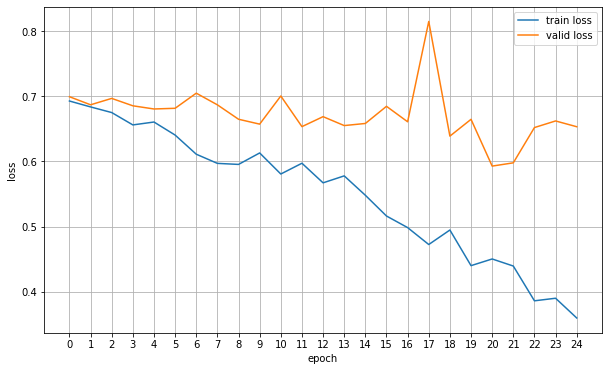

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics["train_losses"], label='train loss')
ax.plot(metrics["valid_losses"], label='valid loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss');
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

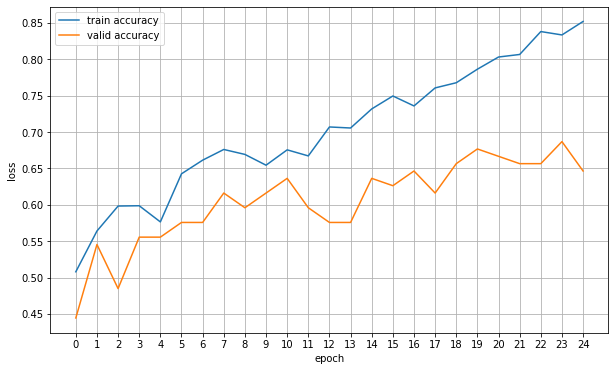

In [31]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(metrics["train_accs"], label='train accuracy')
ax.plot(metrics["valid_accs"], label='valid accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss');
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [32]:
model.load_state_dict(torch.load('lstm.pt'))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100% 1/1 [00:00<00:00, 36.57it/s]


In [33]:
print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

test_loss: 0.656, test_acc: 0.586


In [34]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    input_is_str = False
    if isinstance(text, str):
        text = [text]
        input_is_str = True
    tokens = [tokenizer(t) for t in text]
    length = [len(t) for t in tokens]
    ids = [vocab.lookup_indices(t) for t in tokens]
    tensor = torch.LongTensor(ids).to(device)
    prediction = model(tensor, length)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1)
    predicted_probability = torch.gather(probability, 1, predicted_class.unsqueeze(-1))
    predicted_class = predicted_class.tolist()
    predicted_probability = predicted_probability.squeeze(-1).tolist()
    if input_is_str:
        predicted_class = predicted_class[0]
        predicted_probability = predicted_probability[0]
    return predicted_class, predicted_probability

In [35]:
text = ["This film is terrible!", "This film is great!", "This film is fine."]

predict_sentiment(text, model, tokenizer, vocab, device)

([1, 1, 1], [0.5659620761871338, 0.9439112544059753, 0.8087248206138611])

In [36]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.5659620761871338)